In [5]:
# Import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [6]:
# Define transformations for training and testing data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Data augmentation: Random cropping
    transforms.RandomHorizontalFlip(),    # Data augmentation: Horizontal flipping
    transforms.ToTensor(),                # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

In [7]:
# Load CIFAR-10 dataset
batch_size = 32

train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:13<00:00, 12.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
# Inspect a batch of images
data_iter = iter(train_loader)
images, labels = next(data_iter)

print("Image batch shape:", images.shape)
print("Label batch shape:", labels.shape)


Image batch shape: torch.Size([32, 3, 32, 32])
Label batch shape: torch.Size([32])


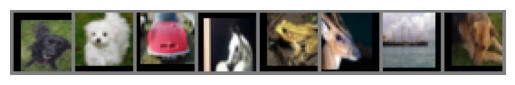

Labels: 5 5 1 7 6 4 8 5


In [9]:
# Function to unnormalize and show images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize from [-1, 1] to [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert to HWC format for plotting
    plt.axis('off')
    plt.show()

# Visualize some images
imshow(torchvision.utils.make_grid(images[:8]))  # Display the first 8 images in a grid
print('Labels:', ' '.join(f'{labels[j].item()}' for j in range(8)))


In [10]:
# CIFAR-10 class labels
classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Print class names for the batch
print('Class labels:', ' '.join(f'{classes[labels[j]]}' for j in range(8)))


Class labels: dog dog automobile horse frog deer ship dog


In [11]:
import torchvision.models as models

# Define ResNet-18
resnet18 = models.resnet18(pretrained=False, num_classes=10)  # Output size matches CIFAR-10 classes

# Define VGG-16
vgg16 = models.vgg16(pretrained=False, num_classes=10)  # Output size matches CIFAR-10 classes

# Define MobileNetV2
mobilenetv2 = models.mobilenet_v2(pretrained=False, num_classes=10)  # Output size matches CIFAR-10 classes

# Print model summaries to confirm architecture
print("ResNet-18:\n", resnet18)
print("VGG-16:\n", vgg16)
print("MobileNetV2:\n", mobilenetv2)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet-18:
 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inpl

In [12]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # For progress bars

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in tqdm(train_loader, desc="Training"):
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Calculate metrics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    accuracy = 100. * correct / total
    avg_loss = running_loss / len(train_loader)
    print(f"Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy

# Evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Calculate metrics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    accuracy = 100. * correct / total
    avg_loss = running_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy


In [9]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize ResNet-18 and move it to the selected device
model = resnet18.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True, weight_decay=5e-4)  # Nesterov momentum

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Decays LR every 30 epochs

# Training and evaluation settings
num_epochs = 10
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Train the model
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate the model
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Step the learning rate scheduler
    scheduler.step()

print("\nTraining Complete!")


Using device: cuda

Epoch 1/10


Training: 100%|██████████| 1563/1563 [00:27<00:00, 56.86it/s]


Train Loss: 1.9414, Train Accuracy: 30.73%


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 167.04it/s]


Test Loss: 1.5781, Test Accuracy: 40.52%

Epoch 2/10


Training: 100%|██████████| 1563/1563 [00:26<00:00, 59.61it/s]


Train Loss: 1.5333, Train Accuracy: 44.42%


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 188.51it/s]


Test Loss: 1.3210, Test Accuracy: 52.53%

Epoch 3/10


Training: 100%|██████████| 1563/1563 [00:26<00:00, 59.63it/s]


Train Loss: 1.3741, Train Accuracy: 51.42%


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 184.81it/s]


Test Loss: 1.4005, Test Accuracy: 52.29%

Epoch 4/10


Training: 100%|██████████| 1563/1563 [00:27<00:00, 57.43it/s]


Train Loss: 1.3047, Train Accuracy: 54.63%


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 187.20it/s]


Test Loss: 1.4723, Test Accuracy: 52.15%

Epoch 5/10


Training: 100%|██████████| 1563/1563 [00:27<00:00, 57.36it/s]


Train Loss: 1.2607, Train Accuracy: 56.33%


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 174.57it/s]


Test Loss: 1.1628, Test Accuracy: 59.58%

Epoch 6/10


Training: 100%|██████████| 1563/1563 [00:27<00:00, 57.24it/s]


Train Loss: 1.2212, Train Accuracy: 57.72%


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 179.47it/s]


Test Loss: 1.2070, Test Accuracy: 58.67%

Epoch 7/10


Training: 100%|██████████| 1563/1563 [00:27<00:00, 57.73it/s]


Train Loss: 1.2035, Train Accuracy: 58.65%


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 182.88it/s]


Test Loss: 1.2642, Test Accuracy: 57.79%

Epoch 8/10


Training: 100%|██████████| 1563/1563 [00:27<00:00, 57.28it/s]


Train Loss: 1.1801, Train Accuracy: 59.45%


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 184.97it/s]


Test Loss: 1.1274, Test Accuracy: 61.51%

Epoch 9/10


Training: 100%|██████████| 1563/1563 [00:27<00:00, 57.66it/s]


Train Loss: 1.1618, Train Accuracy: 59.94%


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 177.51it/s]


Test Loss: 1.1727, Test Accuracy: 60.24%

Epoch 10/10


Training: 100%|██████████| 1563/1563 [00:27<00:00, 56.92it/s]


Train Loss: 1.1563, Train Accuracy: 60.25%


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 181.81it/s]

Test Loss: 1.3527, Test Accuracy: 55.53%

Training Complete!


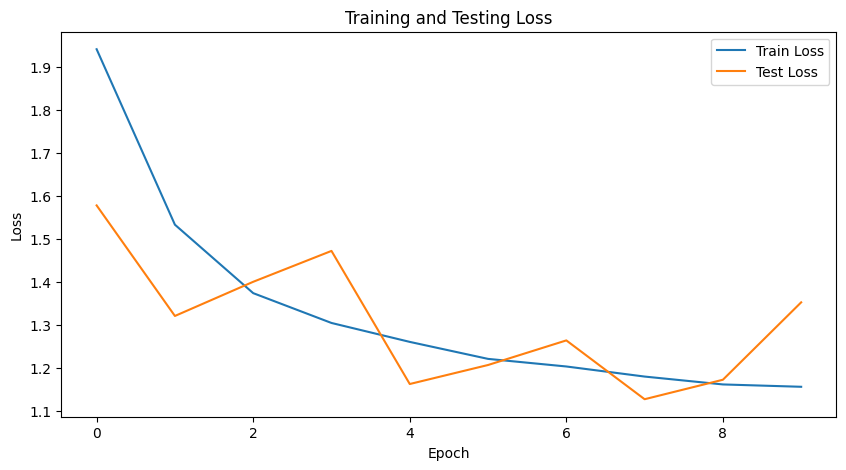

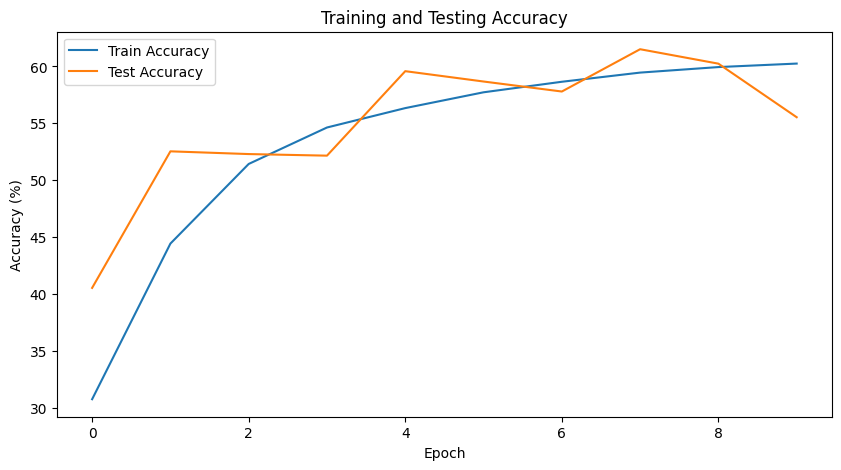

In [10]:
import matplotlib.pyplot as plt

# Plot Training and Testing Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Training and Testing Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


In [11]:
# Initialize VGG-16 and move it to the selected device
model_vgg16 = vgg16.to(device)

# Define loss function and optimizer for VGG-16
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_vgg16.parameters(), lr=0.1, momentum=0.9, nesterov=True, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training settings
num_epochs = 10
vgg16_train_losses, vgg16_train_accuracies = [], []
vgg16_test_losses, vgg16_test_accuracies = [], []

for epoch in range(num_epochs):
    print(f"\n[VGG-16] Epoch {epoch + 1}/{num_epochs}")

    # Train the model
    train_loss, train_accuracy = train(model_vgg16, train_loader, criterion, optimizer, device)
    vgg16_train_losses.append(train_loss)
    vgg16_train_accuracies.append(train_accuracy)

    # Evaluate the model
    test_loss, test_accuracy = evaluate(model_vgg16, test_loader, criterion, device)
    vgg16_test_losses.append(test_loss)
    vgg16_test_accuracies.append(test_accuracy)

    # Step the learning rate scheduler
    scheduler.step()

print("\n[VGG-16] Training Complete!")



[VGG-16] Epoch 1/10


Training: 100%|██████████| 1563/1563 [01:32<00:00, 16.90it/s]


Train Loss: 2.3091, Train Accuracy: 9.93%


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 88.60it/s]


Test Loss: 2.3083, Test Accuracy: 10.00%

[VGG-16] Epoch 2/10


Training: 100%|██████████| 1563/1563 [01:32<00:00, 16.91it/s]


Train Loss: 2.3090, Train Accuracy: 10.05%


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 87.98it/s]


Test Loss: 2.3063, Test Accuracy: 10.00%

[VGG-16] Epoch 3/10


Training: 100%|██████████| 1563/1563 [01:32<00:00, 16.92it/s]


Train Loss: 2.3095, Train Accuracy: 9.97%


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 88.60it/s]


Test Loss: 2.3086, Test Accuracy: 10.00%

[VGG-16] Epoch 4/10


Training: 100%|██████████| 1563/1563 [01:32<00:00, 16.90it/s]


Train Loss: 2.3097, Train Accuracy: 9.82%


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 89.09it/s]


Test Loss: 2.3056, Test Accuracy: 10.00%

[VGG-16] Epoch 5/10


Training: 100%|██████████| 1563/1563 [01:32<00:00, 16.90it/s]


Train Loss: 2.3098, Train Accuracy: 10.00%


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 88.44it/s]


Test Loss: 2.3084, Test Accuracy: 10.00%

[VGG-16] Epoch 6/10


Training: 100%|██████████| 1563/1563 [01:32<00:00, 16.90it/s]


Train Loss: 2.3090, Train Accuracy: 10.10%


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 87.88it/s]


Test Loss: 2.3133, Test Accuracy: 10.00%

[VGG-16] Epoch 7/10


Training: 100%|██████████| 1563/1563 [01:32<00:00, 16.89it/s]


Train Loss: 2.3091, Train Accuracy: 10.11%


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 88.24it/s]


Test Loss: 2.3087, Test Accuracy: 10.00%

[VGG-16] Epoch 8/10


Training: 100%|██████████| 1563/1563 [01:32<00:00, 16.90it/s]


Train Loss: 2.3091, Train Accuracy: 9.71%


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 88.86it/s]


Test Loss: 2.3060, Test Accuracy: 10.00%

[VGG-16] Epoch 9/10


Training: 100%|██████████| 1563/1563 [01:32<00:00, 16.89it/s]


Train Loss: 2.3090, Train Accuracy: 10.00%


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 87.38it/s]


Test Loss: 2.3077, Test Accuracy: 10.00%

[VGG-16] Epoch 10/10


Training: 100%|██████████| 1563/1563 [01:32<00:00, 16.89it/s]


Train Loss: 2.3092, Train Accuracy: 10.05%


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 88.50it/s]

Test Loss: 2.3120, Test Accuracy: 10.00%

[VGG-16] Training Complete!


In [13]:
# Initialize MobileNetV2 and move it to the selected device
model_mobilenetv2 = mobilenetv2.to(device)

# Define loss function and optimizer for MobileNetV2
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_mobilenetv2.parameters(), lr=0.1, momentum=0.9, nesterov=True, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training settings
num_epochs = 10
mobilenetv2_train_losses, mobilenetv2_train_accuracies = [], []
mobilenetv2_test_losses, mobilenetv2_test_accuracies = [], []

for epoch in range(num_epochs):
    print(f"\n[MobileNetV2] Epoch {epoch + 1}/{num_epochs}")

    # Train the model
    train_loss, train_accuracy = train(model_mobilenetv2, train_loader, criterion, optimizer, device)
    mobilenetv2_train_losses.append(train_loss)
    mobilenetv2_train_accuracies.append(train_accuracy)

    # Evaluate the model
    test_loss, test_accuracy = evaluate(model_mobilenetv2, test_loader, criterion, device)
    mobilenetv2_test_losses.append(test_loss)
    mobilenetv2_test_accuracies.append(test_accuracy)

    # Step the learning rate scheduler
    scheduler.step()

print("\n[MobileNetV2] Training Complete!")



[MobileNetV2] Epoch 1/10


Training: 100%|██████████| 1563/1563 [00:34<00:00, 45.28it/s]


Train Loss: 2.3004, Train Accuracy: 18.69%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 130.17it/s]


Test Loss: 1.9539, Test Accuracy: 25.67%

[MobileNetV2] Epoch 2/10


Training: 100%|██████████| 1563/1563 [00:34<00:00, 45.06it/s]


Train Loss: 1.8962, Train Accuracy: 28.58%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 117.78it/s]


Test Loss: 1.9680, Test Accuracy: 27.96%

[MobileNetV2] Epoch 3/10


Training: 100%|██████████| 1563/1563 [00:34<00:00, 44.79it/s]


Train Loss: 1.8069, Train Accuracy: 32.03%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 128.40it/s]


Test Loss: 1.7937, Test Accuracy: 30.91%

[MobileNetV2] Epoch 4/10


Training: 100%|██████████| 1563/1563 [00:34<00:00, 45.44it/s]


Train Loss: 1.7264, Train Accuracy: 35.01%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 124.74it/s]


Test Loss: 2.0253, Test Accuracy: 27.83%

[MobileNetV2] Epoch 5/10


Training: 100%|██████████| 1563/1563 [00:34<00:00, 44.99it/s]


Train Loss: 1.6808, Train Accuracy: 37.01%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 122.23it/s]


Test Loss: 1.6104, Test Accuracy: 40.18%

[MobileNetV2] Epoch 6/10


Training: 100%|██████████| 1563/1563 [00:34<00:00, 45.44it/s]


Train Loss: 1.6434, Train Accuracy: 38.75%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 120.69it/s]


Test Loss: 1.6319, Test Accuracy: 39.67%

[MobileNetV2] Epoch 7/10


Training: 100%|██████████| 1563/1563 [00:34<00:00, 45.46it/s]


Train Loss: 1.6233, Train Accuracy: 39.23%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 121.20it/s]


Test Loss: 1.6535, Test Accuracy: 38.45%

[MobileNetV2] Epoch 8/10


Training: 100%|██████████| 1563/1563 [00:34<00:00, 45.12it/s]


Train Loss: 1.6082, Train Accuracy: 40.45%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 115.05it/s]


Test Loss: 1.9617, Test Accuracy: 30.48%

[MobileNetV2] Epoch 9/10


Training: 100%|██████████| 1563/1563 [00:35<00:00, 44.13it/s]


Train Loss: 1.6028, Train Accuracy: 41.04%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 121.08it/s]


Test Loss: 1.7845, Test Accuracy: 37.02%

[MobileNetV2] Epoch 10/10


Training: 100%|██████████| 1563/1563 [00:34<00:00, 45.04it/s]


Train Loss: 1.5876, Train Accuracy: 41.89%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 125.85it/s]

Test Loss: 1.8083, Test Accuracy: 34.24%

[MobileNetV2] Training Complete!


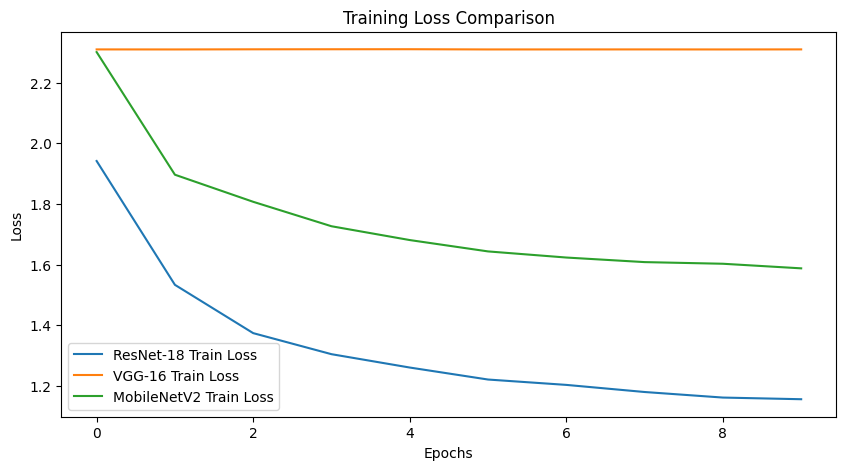

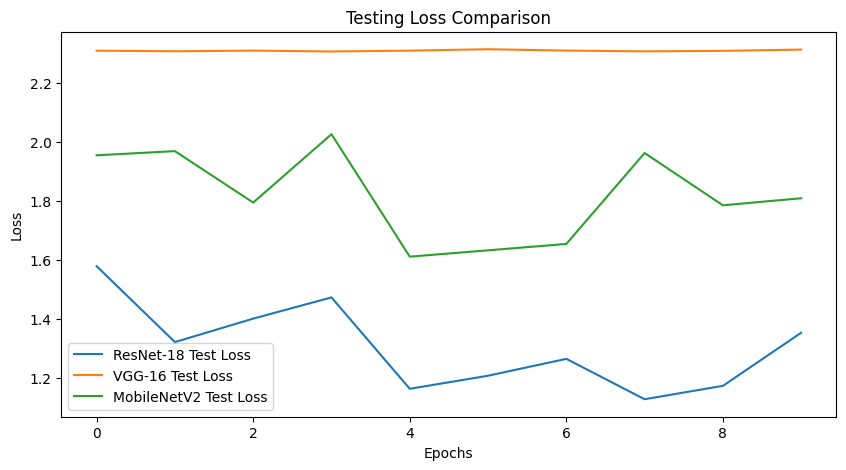

In [14]:
# Plot training loss for all models
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="ResNet-18 Train Loss")
plt.plot(vgg16_train_losses, label="VGG-16 Train Loss")
plt.plot(mobilenetv2_train_losses, label="MobileNetV2 Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()

# Plot testing loss for all models
plt.figure(figsize=(10, 5))
plt.plot(test_losses, label="ResNet-18 Test Loss")
plt.plot(vgg16_test_losses, label="VGG-16 Test Loss")
plt.plot(mobilenetv2_test_losses, label="MobileNetV2 Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Testing Loss Comparison")
plt.legend()
plt.show()


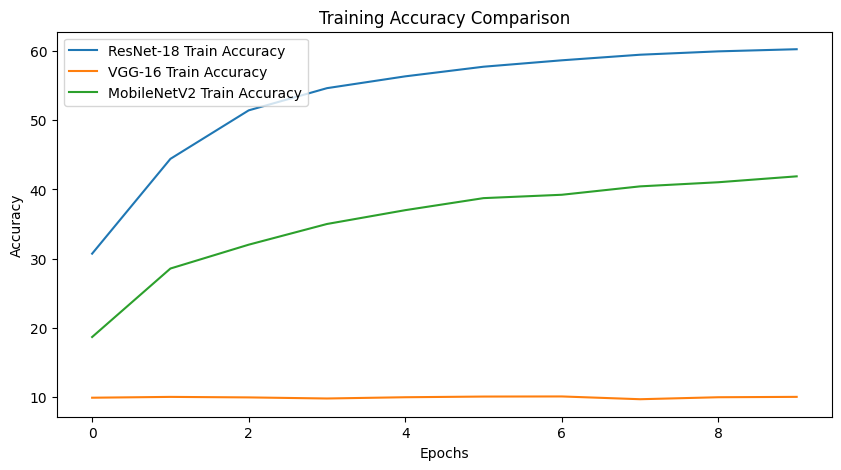

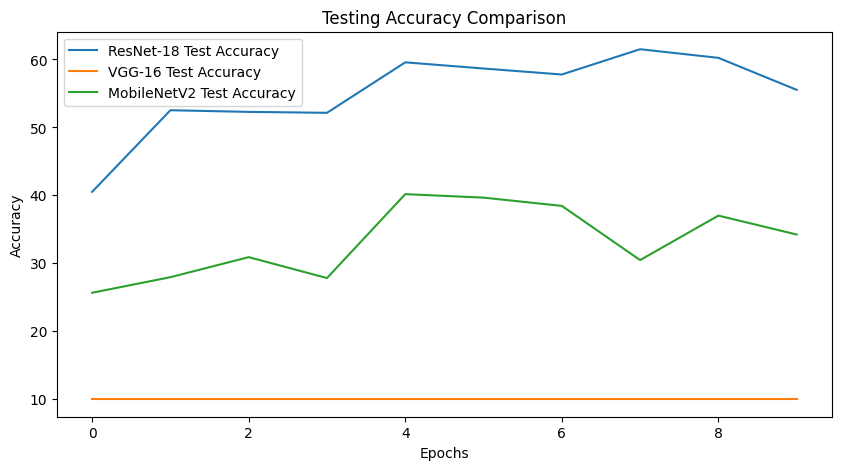

In [15]:
# Plot training accuracy for all models
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="ResNet-18 Train Accuracy")
plt.plot(vgg16_train_accuracies, label="VGG-16 Train Accuracy")
plt.plot(mobilenetv2_train_accuracies, label="MobileNetV2 Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Comparison")
plt.legend()
plt.show()

# Plot testing accuracy for all models
plt.figure(figsize=(10, 5))
plt.plot(test_accuracies, label="ResNet-18 Test Accuracy")
plt.plot(vgg16_test_accuracies, label="VGG-16 Test Accuracy")
plt.plot(mobilenetv2_test_accuracies, label="MobileNetV2 Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Testing Accuracy Comparison")
plt.legend()
plt.show()


In [16]:
import pandas as pd

# Create a summary dataframe
summary_data = {
    "Model": ["ResNet-18", "VGG-16", "MobileNetV2"],
    "Final Test Accuracy (%)": [
        test_accuracies[-1],
        vgg16_test_accuracies[-1],
        mobilenetv2_test_accuracies[-1]
    ],
    "Final Test Loss": [
        test_losses[-1],
        vgg16_test_losses[-1],
        mobilenetv2_test_losses[-1]
    ]
}

summary_df = pd.DataFrame(summary_data)

# Display the summary
print(summary_df)


         Model  Final Test Accuracy (%)  Final Test Loss
0    ResNet-18                    55.53         1.352714
1       VGG-16                    10.00         2.312024
2  MobileNetV2                    34.24         1.808302


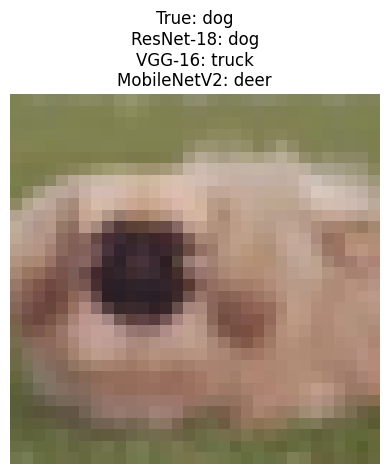

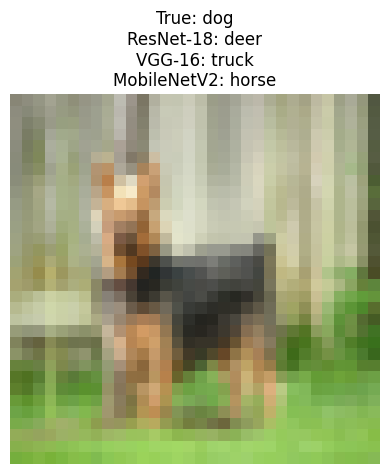

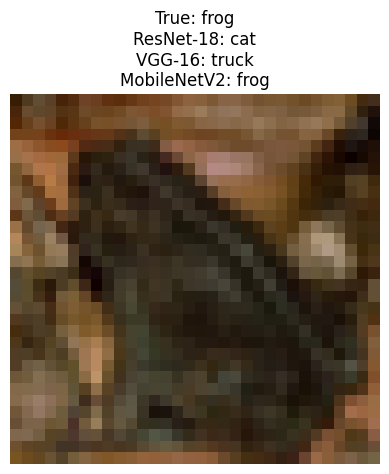

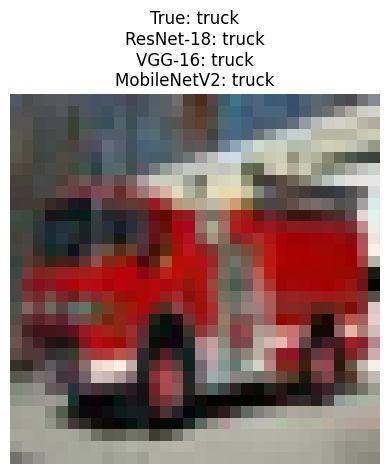

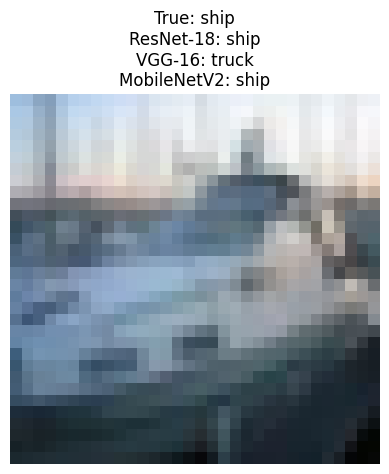

In [17]:
# Function to predict and visualize a single image
def classify_image(model, image, classes, device):
    model.eval()  # Set model to evaluation mode
    image = image.to(device)

    # Add batch dimension to image
    image = image.unsqueeze(0)

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)  # Get predicted class index

    return predicted.item()

# Visualize and classify 5 random test images using all models
import random

# Get 5 random test images
data_iter = iter(test_loader)
images, labels = next(data_iter)
indices = random.sample(range(len(images)), 5)

for idx in indices:
    img, true_label = images[idx], labels[idx]

    # Classify using ResNet-18
    resnet18_prediction = classify_image(resnet18, img, classes, device)
    # Classify using VGG-16
    vgg16_prediction = classify_image(vgg16, img, classes, device)
    # Classify using MobileNetV2
    mobilenetv2_prediction = classify_image(mobilenetv2, img, classes, device)

    # Visualize the image
    plt.imshow(np.transpose(img.numpy() / 2 + 0.5, (1, 2, 0)))  # Unnormalize and convert to HWC
    plt.axis('off')
    plt.title(f"True: {classes[true_label]}\n"
              f"ResNet-18: {classes[resnet18_prediction]}\n"
              f"VGG-16: {classes[vgg16_prediction]}\n"
              f"MobileNetV2: {classes[mobilenetv2_prediction]}")
    plt.show()


In [13]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet3(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet3, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = BasicBlock(16, 32, stride=2)
        self.layer2 = BasicBlock(32, 64, stride=2)
        self.layer3 = BasicBlock(64, 128, stride=2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.global_avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

# Example usage:
resnet3 = ResNet3(num_classes=10)
print(resnet3)


ResNet3(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): BasicBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): BasicBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2

In [14]:
class VGG3(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG3, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Conv Layer 1
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Pooling 1

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Conv Layer 2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Pooling 2

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Conv Layer 3
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling 3
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),  # Adjust based on input size
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Example usage:
vgg3 = VGG3(num_classes=10)
print(vgg3)


VGG3(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [15]:
# Define training and evaluation functions (reuse from earlier)
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in tqdm(train_loader, desc="Training"):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    accuracy = 100. * correct / total
    avg_loss = running_loss / len(train_loader)
    return avg_loss, accuracy

# Evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    accuracy = 100. * correct / total
    avg_loss = running_loss / len(test_loader)
    return avg_loss, accuracy


In [16]:
# Set up device, model, loss, optimizer, and scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

resnet3 = ResNet3(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet3.parameters(), lr=0.1, momentum=0.9, nesterov=True, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training settings
num_epochs = 10
resnet3_train_losses, resnet3_test_losses = [], []
resnet3_train_accuracies, resnet3_test_accuracies = [], []

for epoch in range(num_epochs):
    print(f"\n[ResNet-3] Epoch {epoch + 1}/{num_epochs}")

    train_loss, train_accuracy = train(resnet3, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy = evaluate(resnet3, test_loader, criterion, device)

    resnet3_train_losses.append(train_loss)
    resnet3_train_accuracies.append(train_accuracy)
    resnet3_test_losses.append(test_loss)
    resnet3_test_accuracies.append(test_accuracy)

    scheduler.step()

print("\n[ResNet-3] Training Complete!")


Using device: cuda

[ResNet-3] Epoch 1/10


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 198.34it/s]



[ResNet-3] Epoch 2/10


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 183.33it/s]



[ResNet-3] Epoch 3/10


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 190.93it/s]



[ResNet-3] Epoch 4/10


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 170.60it/s]



[ResNet-3] Epoch 5/10


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 194.93it/s]



[ResNet-3] Epoch 6/10


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 196.79it/s]



[ResNet-3] Epoch 7/10


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 188.03it/s]



[ResNet-3] Epoch 8/10


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 201.00it/s]



[ResNet-3] Epoch 9/10


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 188.35it/s]



[ResNet-3] Epoch 10/10


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 175.06it/s]


[ResNet-3] Training Complete!


In [17]:
# Initialize VGG-3 and move it to the device
vgg3 = VGG3(num_classes=10).to(device)

# Define optimizer and scheduler for VGG-3
optimizer = optim.SGD(vgg3.parameters(), lr=0.1, momentum=0.9, nesterov=True, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Track losses and accuracies
vgg3_train_losses, vgg3_test_losses = [], []
vgg3_train_accuracies, vgg3_test_accuracies = [], []

# Train for the specified number of epochs
for epoch in range(num_epochs):
    print(f"\n[VGG-3] Epoch {epoch + 1}/{num_epochs}")

    train_loss, train_accuracy = train(vgg3, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy = evaluate(vgg3, test_loader, criterion, device)

    # Log losses and accuracies
    vgg3_train_losses.append(train_loss)
    vgg3_train_accuracies.append(train_accuracy)
    vgg3_test_losses.append(test_loss)
    vgg3_test_accuracies.append(test_accuracy)

    scheduler.step()

print("\n[VGG-3] Training Complete!")



[VGG-3] Epoch 1/10


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 198.29it/s]



[VGG-3] Epoch 2/10


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 191.26it/s]



[VGG-3] Epoch 3/10


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 189.74it/s]



[VGG-3] Epoch 4/10


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 197.10it/s]



[VGG-3] Epoch 5/10


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 187.94it/s]



[VGG-3] Epoch 6/10


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 180.93it/s]



[VGG-3] Epoch 7/10


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 181.02it/s]



[VGG-3] Epoch 8/10


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 176.06it/s]



[VGG-3] Epoch 9/10


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 186.27it/s]



[VGG-3] Epoch 10/10


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 185.54it/s]


[VGG-3] Training Complete!


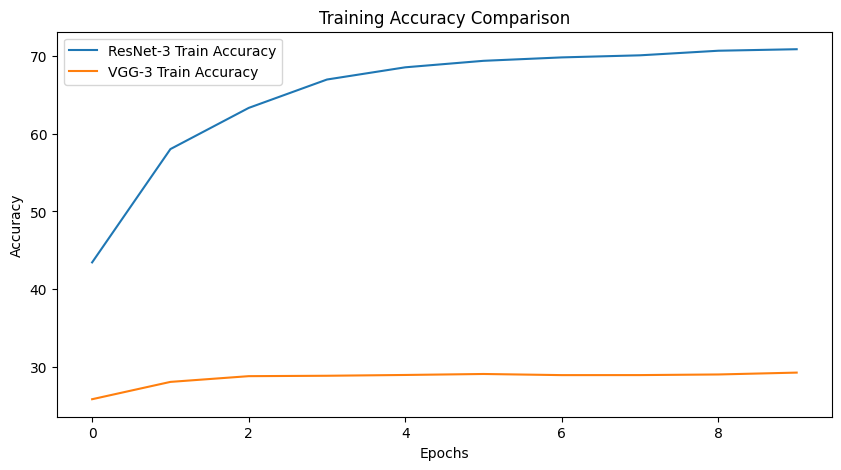

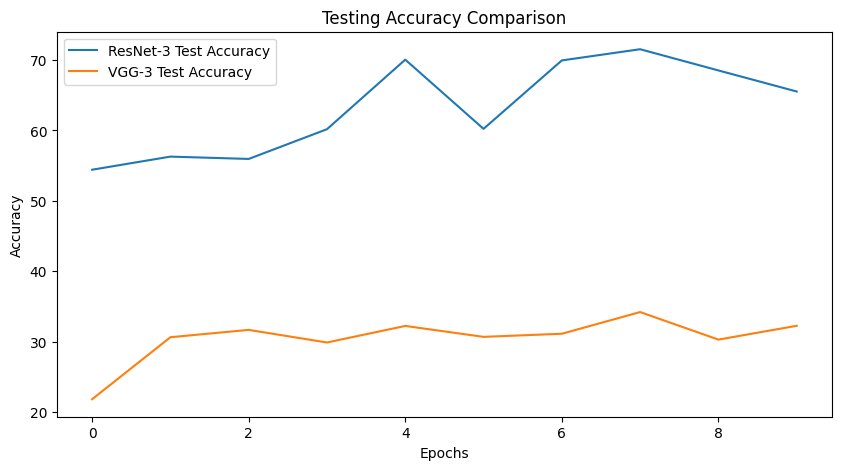

In [19]:
import matplotlib.pyplot as plt

# Plot training accuracy for ResNet-3 and VGG-3
plt.figure(figsize=(10, 5))
plt.plot(resnet3_train_accuracies, label="ResNet-3 Train Accuracy")
plt.plot(vgg3_train_accuracies, label="VGG-3 Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Comparison")
plt.legend()
plt.show()

# Plot testing accuracy for ResNet-3 and VGG-3
plt.figure(figsize=(10, 5))
plt.plot(resnet3_test_accuracies, label="ResNet-3 Test Accuracy")
plt.plot(vgg3_test_accuracies, label="VGG-3 Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Testing Accuracy Comparison")
plt.legend()
plt.show()


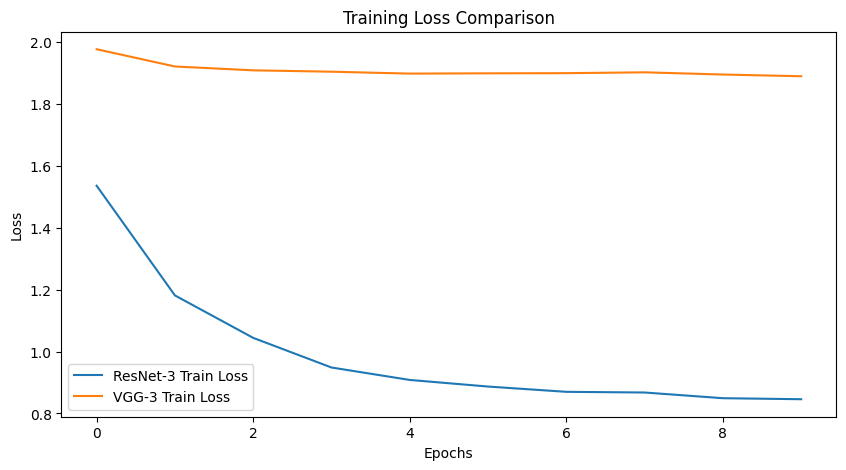

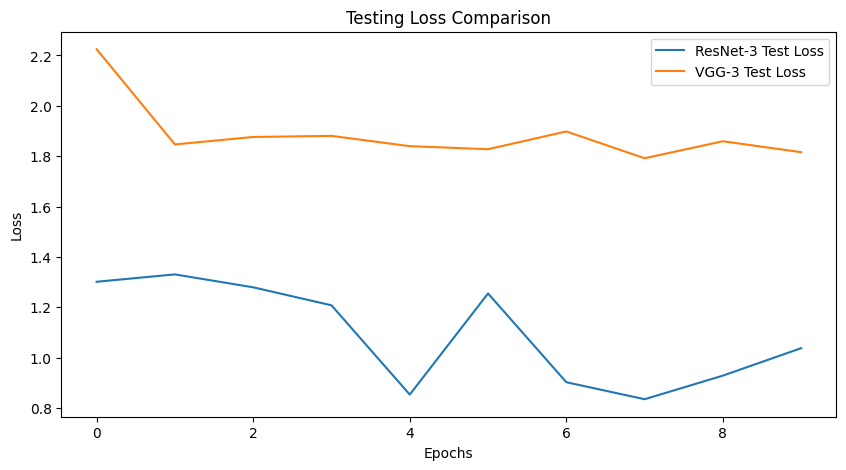

In [20]:
# Plot training loss for ResNet-3 and VGG-3
plt.figure(figsize=(10, 5))
plt.plot(resnet3_train_losses, label="ResNet-3 Train Loss")
plt.plot(vgg3_train_losses, label="VGG-3 Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()

# Plot testing loss for ResNet-3 and VGG-3
plt.figure(figsize=(10, 5))
plt.plot(resnet3_test_losses, label="ResNet-3 Test Loss")
plt.plot(vgg3_test_losses, label="VGG-3 Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Testing Loss Comparison")
plt.legend()
plt.show()


In [21]:
import pandas as pd

# Create a summary dataframe
summary_data = {
    "Model": ["ResNet-3", "VGG-3"],
    "Final Test Accuracy (%)": [
        resnet3_test_accuracies[-1],
        vgg3_test_accuracies[-1]
    ],
    "Final Test Loss": [
        resnet3_test_losses[-1],
        vgg3_test_losses[-1]
    ]
}

summary_df = pd.DataFrame(summary_data)

# Display the summary
print(summary_df)


      Model  Final Test Accuracy (%)  Final Test Loss
0  ResNet-3                    65.52         1.037333
1     VGG-3                    32.27         1.815879


In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Function to classify and visualize a single image
def classify_image(model, image, classes, device):
    model.eval()  # Set model to evaluation mode
    image = image.to(device)  # Send the image to the same device as the model

    # Add a batch dimension to the image (required for the model)
    image = image.unsqueeze(0)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = outputs.max(1)  # Get the class index with the highest probability

    return predicted.item()  # Return the predicted class index


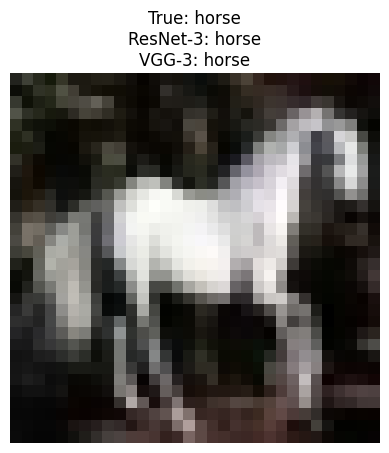

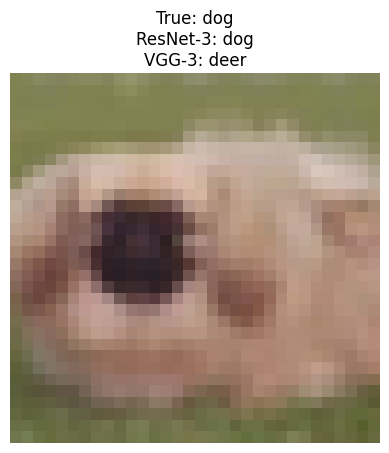

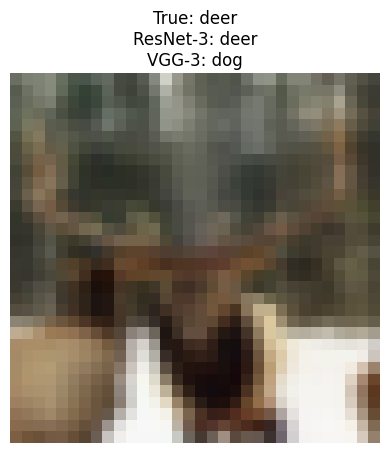

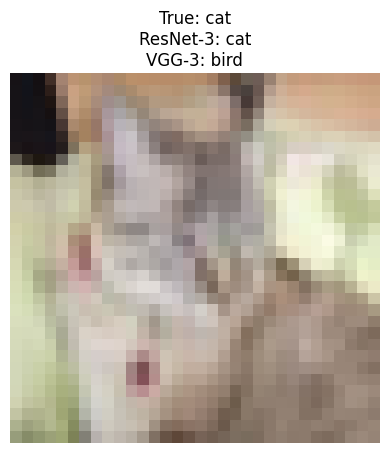

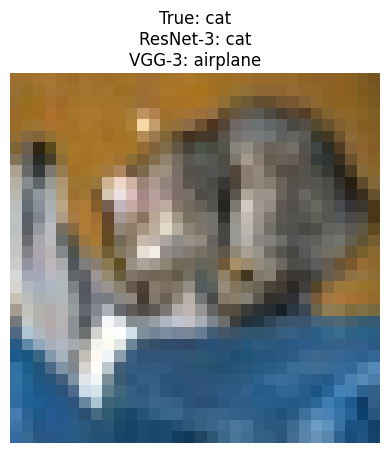

In [23]:
# CIFAR-10 class labels
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Get a batch of images from the test set
data_iter = iter(test_loader)
images, labels = next(data_iter)

# Select random indices to test
import random
random_indices = random.sample(range(len(images)), 5)  # Choose 5 random images

# Test ResNet-3 and VGG-3
for idx in random_indices:
    image, true_label = images[idx], labels[idx]

    # Predict using ResNet-3
    resnet3_prediction = classify_image(resnet3, image, classes, device)
    resnet3_class = classes[resnet3_prediction]

    # Predict using VGG-3
    vgg3_prediction = classify_image(vgg3, image, classes, device)
    vgg3_class = classes[vgg3_prediction]

    # Visualize the image
    plt.imshow(np.transpose(image.numpy() / 2 + 0.5, (1, 2, 0)))  # Unnormalize and convert to HWC
    plt.axis('off')
    plt.title(f"True: {classes[true_label]}\n"
              f"ResNet-3: {resnet3_class}\n"
              f"VGG-3: {vgg3_class}")
    plt.show()
